# fMRI analysis


### Functional and anatomical images
Functional magnetic resonance images(fMRI) consists of a sequence of 3D scans of the brain recorded over time. Here, we will refer to those images as "functional", while we will call "anatomical" those ones which don't have the time dimension (for example T1 or T2). These images are characterized by higher resolution and thus can be used as a reference for advanced image processing transformations.

For each subject we have between 1 and 3 sessions of resting state (RS) fMRI scans. Resting state is a condition for which the recording is performed while the subject is not performing any task (at rest). In literature it has been shown that from this condition it is possible to detect networks of the brain that are always active. These networks, which have been found to be consistent in healthy subjects, are destroyed in many neurological diseases. 

Furthermore, for each subject we have different anatomical scans. In particular we will be interested in T1 scans that will be used to align and normalize the functional data.

### Subjects
Subjects can be divided in two groups: 

* Parkinson's disease

* Control

The number of subjects in the two groups is not balanced, thus for our analysis we need to compensate the unbalance.

## Data conversion and normalzation
Before pre-processing the data, the following steps have been performed through bash commands:

1) Format conversion (from DICOM to nIfTi):


```
dcm2niix -b y -f %i_%d_%t -o ./PPMI_formatted/ ./PPMI/
``` 


2) Data structure organization (BIDS: http://bids.neuroimaging.io/)
``` 
import os
subjects = os.listdir()
subjects = [subject[:4] for subject in subjects]
subjects = list(set(subjects))
for subject in subjects:
	os.system('mkdir ' +subject)
	os.system('mkdir ' +subject+'/func')
	os.system('mv '+subject+'* ' +subject+'/func')
```

## Data inspection
Here we are going to inspect the nIfTi files obtained through the format conversion.
The names of the images have been saved in a .txt file after the conversion was performed.

Some of the files, characterized with the ending "e1" or "e2", have been duplicated during the conversion. For the moment we mark them as "duplic".

Each nIfTi image could be either a functional or anatomical MRI scan and could belong to a patient or a control subject. To get this information we will use a .csv file that was provided when the data was


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
df_converted = pd.read_table('nii_files.txt', header=None)
df_converted.columns = ['nIfTi files']

In [3]:
# Save subjects IDs
df_converted['Subject'] = df_converted['nIfTi files'].apply(lambda x: x[15:19])

# Check when the string finishes with e2 / e1, that means that the file has been 
#replicated and flag those ones as "repeated", then save teh session code and the image type
df_converted['Date'] = df_converted['nIfTi files'].apply(lambda x: x[-21:-13] if x[-6] == 'e' in str(x) else x[-18:-10])
df_converted['Duplic'] = df_converted['nIfTi files'].apply(lambda x: 1 if x[-6] == 'e' in str(x) else 0)
df_converted['Description'] = df_converted['nIfTi files'].apply(lambda x: x[20:-22] if x[-6] == 'e' in str(x) else x[20:-19])


In [4]:
df_converted = df_converted.drop(['nIfTi files'], axis=1)
df_converted.head()

,Subject,Date,Duplic,Description
0,3102,20101123,0,Axial_PD-T2_TSE
1,3102,20101123,1,Axial_PD-T2_TSE
2,3102,20111121,0,Axial_PD-T2_TSE
3,3102,20111121,1,Axial_PD-T2_TSE
4,3102,20101123,0,MPRAGE_GRAPPA


Now we can check how many types of images we have:

In [5]:
df_converted['Description'].unique()

array(['Axial_PD-T2_TSE', 'MPRAGE_GRAPPA', 'MPRAGE_GRAPPA2',
       'Axial_PD-T2_TSE_FS', 'MPRAGE_T1_SAG', 'ep2d_RESTING_STATE',
       'FLAIR_AXIAL', 'MPRAGE_GRAPPA_2', 'Axial_PD-T2_TSE_FS_201',
       'Axial_PD-T2_TSE_FS_', 'AXIAL_PD-T2_TSE_FS', 'MPRAGE_GRAPPA_ADNI',
       'Axial_PD-T2_TSE_2013', 'Axial_PD-T2_TSE_2013031',
       'MPRAGE_GRAPPA_ND', 'Axial_PD-T2_TSE_FS_2012',
       'Axial_PD-T2_TSE_FS_20121116', 'Axial_PD-T2_TSE_FS_20121',
       'Axial_PD-T2_TSE_FS_20141128', 'Axial_PD-T2_TSE_FS_20141',
       'MPRAGE_GRAPPA_', 'ep2d_bold_rest', 'AXIAL_PD-T2_TSE_FS_201',
       'MPRAGE_GRAPPA_ADNI_'], dtype=object)

They seem to be a lot, but in fact we can cathegorize them in three main groups:
* anatomical T1 MRI (keywords: T1, MPRAGE)
* anatomical T2 MRI (keyword: T2)
* resting state functional MRI (keywords: ep2d, rest)
We can set those keyworkds to flag the data. Also, we want to keep the information that tells us whether the image is axial, sagittal or complete.

In [6]:
def convType(type1):
    if 'T2' in type1:
        if "Axial" in type1 or "AXIAL" in type1:
            return "T2_AX"
        else:
            return "T2"
    if 'MPRAGE' in type1:
        if "SAG" in type1:
            return "T1_SAG"
        else:
            return "T1"
    if 'ep2d' in type1:
        return 'Rest'
    else:
        return type1

In [7]:
df_converted['MRI type'] = df_converted['Description'].apply(lambda x: convType(x))
df_converted.head()

,Subject,Date,Duplic,Description,MRI type
0,3102,20101123,0,Axial_PD-T2_TSE,T2_AX
1,3102,20101123,1,Axial_PD-T2_TSE,T2_AX
2,3102,20111121,0,Axial_PD-T2_TSE,T2_AX
3,3102,20111121,1,Axial_PD-T2_TSE,T2_AX
4,3102,20101123,0,MPRAGE_GRAPPA,T1


In [8]:
df_converted['MRI type'].unique()

array(['T2_AX', 'T1', 'T1_SAG', 'Rest', 'FLAIR_AXIAL'], dtype=object)

Now we look at the metadata file that includes some information on each subject and image

In [65]:
df_metadata = pd.read_csv('final_collection_11_28_2017.csv')
df_metadata = df_metadata.drop(['Format', 'Downloaded', 'Type', 'Visit'], axis=1)

In [66]:
df_metadata.head()

,Image Data ID,Subject,Group,Sex,Age,Modality,Description,Acq Date
0,367450,4038,PD,F,71,MRI,Axial PD-T2 TSE FS,4/01/2013
1,430210,4038,PD,F,72,fMRI,ep2d_RESTING_STATE,4/21/2014
2,430211,4038,PD,F,72,MRI,MPRAGE GRAPPA,4/21/2014
3,430213,4038,PD,F,72,MRI,Axial PD-T2 TSE FS,4/21/2014
4,430215,4038,PD,F,72,MRI,Axial PD-T2 TSE FS,4/21/2014


We begin with looking at some basic attributes of our dataset such as age distribution

In [67]:
# To not have multiple instances of the same patients we only take the earliest image
metadata_firstYear = df_metadata.drop_duplicates(subset="Subject",keep='first')

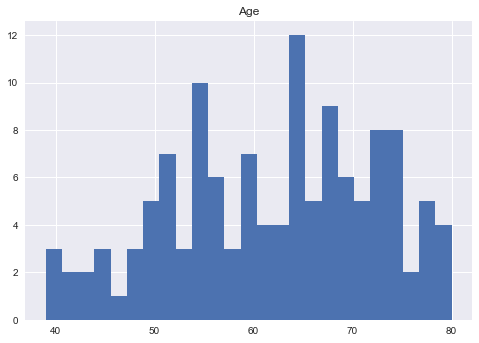

In [68]:
metadata_firstYear.hist(column='Age',bins=25)
plt.show()

How the dataset is devided between male and female.
Note that PD is also more frequent among males in the general population

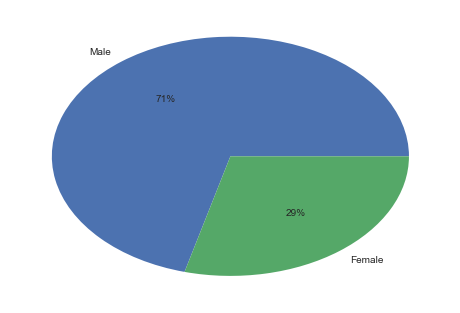

In [69]:
n_female = len(metadata_firstYear[metadata_firstYear["Sex"]=='F'])
n_male = len(metadata_firstYear[metadata_firstYear["Sex"]=='M'])
plt.pie([n_male,n_female], labels=['Male','Female'],autopct='%.0f%%')
plt.show()

How many subjects are Parkinson's disease patients and how many are healthy controls

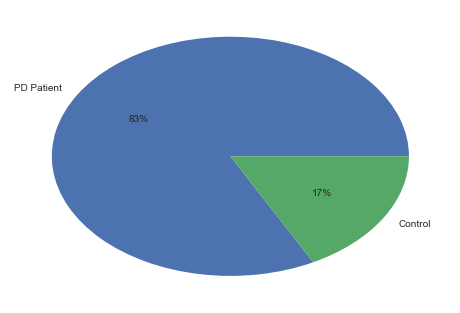

In [70]:
n_PD = len(metadata_firstYear[metadata_firstYear["Group"]=='PD'])
n_Control = len(metadata_firstYear[metadata_firstYear["Group"]=='Control'])
plt.pie([n_PD,n_Control], labels=['PD Patient','Control'], autopct='%.0f%%')
plt.show()

Check if the age distribution between healthy and PD patients any different

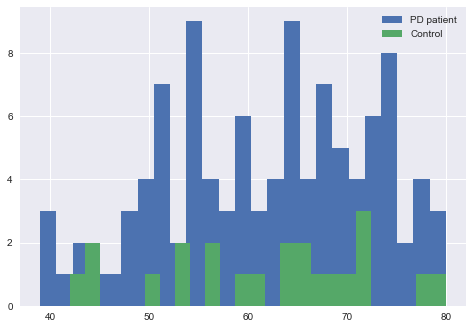

In [79]:
plt.hist(metadata_firstYear[metadata_firstYear["Group"]=='PD']['Age'],bins=25,label='PD patient')
plt.hist(metadata_firstYear[metadata_firstYear["Group"]=='Control']['Age'],bins=25, label='Control')
plt.legend()
plt.show()

How about age difference between female and male patients

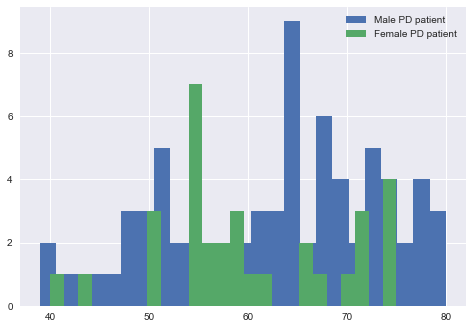

In [93]:
plt.hist(metadata_firstYear[(metadata_firstYear["Group"]=='PD') & (metadata_firstYear["Sex"]=='M')]['Age'],bins=25,label='Male PD patient')
plt.hist(metadata_firstYear[(metadata_firstYear["Group"]=='PD') & (metadata_firstYear["Sex"]=='F')]['Age'],bins=25,label='Female PD patient')
plt.legend()
plt.show()

Overall the dataset seems to be well balanced in age but there are considerable more men than women. This might be caused by the fact that males are more often affected than females